# Meta-Embedded Clustering (MEC)

In [1]:
# Import the librairies
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from pathlib import Path

import umap
from hdbscan.validity import validity_index
from hdbscan import HDBSCAN, all_points_membership_vectors

import torch
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18, VGG16_Weights, vgg16, DenseNet121_Weights, densenet121, AlexNet_Weights, alexnet
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from kneed import KneeLocator

from darksound.dataset import Darksound
from darksound.config import load_config

from darksound.networks.protonet import PrototypicalNetworks
from darksound.networks.matchnet import MatchingNetworks
from darksound.networks.relatnet import RelationNetworks

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_features(model, spectrogram, device, params):
    # Extract the features from the model
    if params['PARAMS_MODEL']['NETWORK'] == 'relation':
        relation_features = Relation(model.backbone).to(device)
        features = relation_features(spectrogram.to(device).unsqueeze(dim=0))
    else:
        features = model.backbone.forward(spectrogram.to(device).unsqueeze(dim=0)).squeeze(dim=0)
    # Detach and convert to numpy array 
    return features.detach().cpu().numpy()

def evaluation(features, true_labels, clusterer):
    # Remove noisy samples indexes from pseudo and true labels
    pseudo_labels = clusterer.labels_
    clustered = pseudo_labels >= 0
    # Compute evaluation metrics
    ari = adjusted_rand_score(true_labels[clustered], pseudo_labels[clustered])
    ami = adjusted_mutual_info_score(true_labels[clustered], pseudo_labels[clustered])
    # sometimes the validity index can't be computed
    try :
        dbcv, per_cluster_dbcv = validity_index(features.astype(np.float64), pseudo_labels, metric='euclidean', per_pseudo_label_id_scores=True)
    except:
        dbcv = 0
        per_cluster_dbcv = [0]
    return ari, ami, dbcv, per_cluster_dbcv 

def get_clusterer(features, n_components, method_reduc='PCA', method_cluster='DBSCAN', random_seed = 1979) :
    if method_reduc == 'PCA':
        # Linear reduction of dimensionality of the latent space 
        pca = PCA(n_components=n_components, random_state=random_seed)
        embedding = pca.fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 
    elif method_reduc == 'TSVD':  
        # Linear reduction of dimensionality of the latent space
        embedding = TruncatedSVD(n_components=n_components, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 
    elif method_reduc == 'UMAP':
        # Nonlinear reduction of dimensionality of the latent space
        embedding = umap.UMAP(densmap=True, n_components=n_components, n_jobs=-1, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 
    else:
        embedding = features
        k = n_components * 2

    # Calculate average distance between each point in the data set and its k-nearest neighbors (k corresponds to min_points).
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(embedding)
    distances, indices = neighbors_fit.kneighbors(embedding, n_neighbors=k)
    # Sort distance values by ascending value and plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1] 
    # Find the knee (curvature inflexion point)
    kneedle = KneeLocator(
        x = np.arange(0, len(distances), 1),
        y = distances,
        interp_method = "polynomial",
        curve = "convex",
        direction = "increasing")
    eps = float(kneedle.knee_y)  

    if method_cluster == 'HDBSCAN':
        # Perform HDBSCAN clustering from embedding array (min_cluster_size is equivalent to min_samples in DBSCAN)
        # clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2).fit(embedding)
        # clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2, cluster_selection_epsilon=eps).fit(embedding)
        clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2, cluster_selection_epsilon=eps, prediction_data=True).fit(embedding)
    elif method_cluster == 'DBSCAN':
        # Perform DBSCAN clustering from embedding array
        clusterer = DBSCAN(min_samples=k, eps=eps).fit(embedding)

    return clusterer, embedding

## Import config file

In [3]:
# path to the parent folder
parent_path = "..//darksound"

# Import config file and load parameters
params = load_config(f'{parent_path}//config.yaml')

# Set the seed for all random packages that could possibly be used
random_seed = params['RANDOM_SEED']
np.random.seed(random_seed)

bambird.extract_rois_full_sig


## Load the Darksound dataset

In [4]:
# Load the Darksound dataset
test_set = Darksound(split='test', 
                    hpss=params['PARAMS_MODEL']['HPSS'], 
                    remove_background=params['PARAMS_MODEL']['REMOVE_BG'], 
                    transform=None,
                    n_classes=30,
                    download=True,
                    )
# Get the ground truth labels
true_labels = np.array(test_set.__getlabel__())


The config file /media/haupert/data/mes_projets/15_darksound/darksound.git/notebooks/config.yaml could not be loaded. Default parameters are loaded
Files already downloaded and verified


## Clusters examination

For each cluster, compute the species distribution, find the main species.

For each species, find how many samples are kept, in how many clusters

In [5]:
#--------------------------------------------------------------------------
# PREPARE THE DATA FOR THE CLUSTERING
#--------------------------------------------------------------------------
features = np.load(f'{parent_path}//embeddings//features//prototypical-networks-5way-1shot-densenet-30classes.npy')
n_components = 10
method_reduc = 'UMAP'
method_cluster = 'HDBSCAN'

# find the clusters
clusterer, embedding = get_clusterer(
                                features=features, 
                                n_components=n_components, 
                                method_reduc=method_reduc, 
                                method_cluster=method_cluster,
                                random_seed=random_seed)

# Get the predicted labels and the number of clusters
pseudo_labels = clusterer.labels_ 
clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

# Compute evaluation metrics
ari, ami, dbcv, per_cluster_dbcv = evaluation(embedding, true_labels, clusterer)
print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCVavg: {np.mean(per_cluster_dbcv)}\n')


Clustering 76% of the data: Found 37 clusters with n_components=10.
ARI: 0.6535015266887666
AMI: 0.7947993488254292
DBCV: 0
DBCVavg: 0.0



In [6]:
# Combine the species name with the labels to create a dictionnary
species_dict = {}
for t in zip(test_set._species, np.unique(test_set.__getlabel__())) :
    # add element in a dictionnary
    species_dict[t[1]] = t[0]


In [7]:
# For each cluster, print the species with the number of points per species
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        print(f'Cluster {pseudo_label_id} :')
        for true_label_id in np.unique(true_labels) :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) > 0:
                print(f'    {species_dict[true_label_id]} : {np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id))}')

Cluster 0 :
    Crypturellus soui_Little Tinamou : 1
    Nyctibius griseus_Common Potoo : 1
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 1
    Glaucidium hardyi_Amazonian Pygmy Owl : 1
    Nyctipolus nigrescens_Blackish Nightjar : 31
    Nyctidromus albicollis_Pauraque : 588
    Nyctibius grandis_Great Potoo : 4
Cluster 1 :
    Hydropsalis cayennensis_White-tailed Nightjar : 20
Cluster 2 :
    Hydropsalis cayennensis_White-tailed Nightjar : 35
Cluster 3 :
    Hydropsalis cayennensis_White-tailed Nightjar : 17
    Hydropsalis maculicaudus_Spot-tailed Nightjar : 340
Cluster 4 :
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 1
    Micrastur gilvicollis_Lined Forest Falcon : 1
    Micrastur ruficollis_Barred Forest Falcon : 43
Cluster 5 :
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 1
    Nyctipolus nigrescens_Blackish Nightjar : 47
Cluster 6 :
    Nyctiprogne leucopyga_Band-tailed Nighthawk : 138
    Lurocalis semitorquatus_Short-tailed Nighthawk : 4
Cluster 7 :
    Nyctiprog

In [8]:
# Find the label in true_labels that are not present in pseudo_labels
missing_species_any_cluster = np.setdiff1d(true_labels, pseudo_labels)

print(f'{len(missing_species_any_cluster)} / {len(species_dict)} species are not present in any cluster.')

print("The list is:")
for nn in missing_species_any_cluster :
    print(f'    {species_dict[nn]}')


0 / 30 species are not present in any cluster.
The list is:


In [9]:
# list of labels corresponding to the most represented species in each cluster
label_to_cluster = []

# For each cluster, select the species with the most points and compute the percentage of points in the cluster
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        label_to_cluster += [np.unique(true_labels)[np.argmax([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) for true_label_id in np.unique(true_labels)])]]
        print(f'Cluster {pseudo_label_id} : {species_dict[label_to_cluster[-1]]} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label_to_cluster[-1])) / np.sum(pseudo_labels == pseudo_label_id) * 100).astype("int")}%')

Cluster 0 : Nyctidromus albicollis_Pauraque : 94%
Cluster 1 : Hydropsalis cayennensis_White-tailed Nightjar : 100%
Cluster 2 : Hydropsalis cayennensis_White-tailed Nightjar : 100%
Cluster 3 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 95%
Cluster 4 : Micrastur ruficollis_Barred Forest Falcon : 96%
Cluster 5 : Nyctipolus nigrescens_Blackish Nightjar : 98%
Cluster 6 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 97%
Cluster 7 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 93%
Cluster 8 : Lurocalis semitorquatus_Short-tailed Nighthawk : 97%
Cluster 9 : Lurocalis semitorquatus_Short-tailed Nighthawk : 96%
Cluster 10 : Pulsatrix perspicillata_Spectacled Owl : 89%
Cluster 11 : Lophostrix cristata_Crested Owl : 85%
Cluster 12 : Strix huhula_Black-banded Owl : 100%
Cluster 13 : Micrastur ruficollis_Barred Forest Falcon : 100%
Cluster 14 : Micrastur ruficollis_Barred Forest Falcon : 100%
Cluster 15 : Strix huhula_Black-banded Owl : 81%
Cluster 16 : Strix huhula_Black-banded Owl : 95%
Clu

In [10]:
# list of species that are not the most represented in any cluster
missing_species_as_main_cluster = np.setdiff1d(np.unique(true_labels), label_to_cluster)

print(f'{len(missing_species_as_main_cluster)} / {len(species_dict)} species are not representing by a cluster.')

print("The list is:")
for label in missing_species_as_main_cluster :
    print(f'    {species_dict[label]}')

10 / 30 species are not representing by a cluster.
The list is:
    Chordeiles acutipennis_Lesser Nighthawk
    Crypturellus soui_Little Tinamou
    Nyctibius leucopterus_White-winged Potoo
    Hydropsalis climacocerca_Ladder-tailed Nightjar
    Chordeiles nacunda_Nacunda Nighthawk
    Glaucidium hardyi_Amazonian Pygmy Owl
    Crypturellus variegatus_Variegated Tinamou
    Crypturellus brevirostris_Rusty Tinamou
    Megascops roraimae_Foothill Screech Owl
    Nyctibius bracteatus_Rufous Potoo


## Multiple UMAP

The idea is to perform 
1. multiple UMAP reduction with different 
2. find the clusters from the vectors found after the UMAP reduction
3. create a matrix with n rows corresponding to the number of samples and m columns corresponding to the number of clustering

The goal is to have a better estimation of the samples that are similar (always in the same cluster)

Methods to group the samples
- pairwise distance then clustering on the distance (kmeans ?)
- find similar sequence of numbers (DNA...)
- find similar sequence of categories

In [5]:
#--------------------------------------------------------------------------
# PREPARE THE DATA FOR THE CLUSTERING
#--------------------------------------------------------------------------
features = np.load(f'{parent_path}//embeddings//features//prototypical-networks-5way-1shot-densenet-30classes.npy')
n_components = np.arange(2,10)
method_reduc = 'UMAP'
method_cluster = 'HDBSCAN'
seeds = np.arange(10)

pseudo_labels_list = []

# find the clusters
for n_component in n_components :
    clusterer, embedding = get_clusterer(
                                    features=features, 
                                    n_components=n_component, 
                                    method_reduc=method_reduc, 
                                    method_cluster=method_cluster,
                                    random_seed=random_seed)

    # Get the predicted labels and the number of clusters
    pseudo_labels = clusterer.labels_ 
    clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
    percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
    print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

    # Compute evaluation metrics
    ari, ami, dbcv, per_cluster_dbcv = evaluation(embedding, true_labels, clusterer)
    print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCVavg: {np.mean(per_cluster_dbcv)}\n')

    pseudo_labels_list += [pseudo_labels]


Clustering 87% of the data: Found 328 clusters with n_components=[2 3 4 5 6 7 8 9].
ARI: 0.4360152355827616
AMI: 0.6360771840184074
DBCV: 0
DBCVavg: 0.0


Clustering 81% of the data: Found 159 clusters with n_components=[2 3 4 5 6 7 8 9].
ARI: 0.5878304622962737
AMI: 0.7227344512389194
DBCV: 0
DBCVavg: 0.0


Clustering 77% of the data: Found 103 clusters with n_components=[2 3 4 5 6 7 8 9].
ARI: 0.641841251033311
AMI: 0.766865800582363
DBCV: 0
DBCVavg: 0.0


Clustering 80% of the data: Found 74 clusters with n_components=[2 3 4 5 6 7 8 9].
ARI: 0.6234576614510361
AMI: 0.7680843553648916
DBCV: 0
DBCVavg: 0.0


Clustering 77% of the data: Found 56 clusters with n_components=[2 3 4 5 6 7 8 9].
ARI: 0.6461416475318921
AMI: 0.7926730835711495
DBCV: 0
DBCVavg: 0.0


Clustering 77% of the data: Found 48 clusters with n_components=[2 3 4 5 6 7 8 9].
ARI: 0.6564899783053012
AMI: 0.8017035380448676
DBCV: 0
DBCVavg: 0.0


Clustering 77% of the data: Found 47 clusters with n_components=[2 3 4 5 6

In [6]:
# Transposition of the list of pseudo_labels
sequence_cluster_ids = np.array(pseudo_labels_list).T

In [7]:
# transform integer (Cluster ID) into string such as 'C0'
sequence_cluster_ids_str = np.array([f'C{cluster_id}' if cluster_id != -1 else 'Noise' for cluster_id in sequence_cluster_ids.flatten()]).reshape(sequence_cluster_ids.shape)

# add an index as a new dimension at the beginning of the array
sequence_cluster_ids_str_with_index = np.array([[i+1, sequence_cluster_ids_str[i]] for i in range(sequence_cluster_ids_str.shape[0])])

# convert the array into a pandas DataFrame
df_sequence_cluster_ids = pd.DataFrame(sequence_cluster_ids_str_with_index, columns=['id', 'sequence'])
df_sequence_cluster_ids

,id,sequence
0,1,"[C255, Noise, Noise, Noise, Noise, Noise, Nois..."
1,2,"[C181, C80, C73, C41, C32, C23, C21, C24]"
2,3,"[Noise, C80, C73, C41, C32, C23, C21, C24]"
3,4,"[C181, C80, C73, C41, C32, C23, C21, C24]"
4,5,"[C56, Noise, Noise, Noise, Noise, Noise, Noise..."
...,...,...
8158,8159,"[C134, C78, Noise, C49, C34, Noise, Noise, Noise]"
8159,8160,"[C137, C78, Noise, C49, C34, C24, C22, C25]"
8160,8161,"[Noise, C105, C85, C49, C34, C24, C22, C25]"
8161,8162,"[C137, C78, Noise, C49, C34, C24, C22, C25]"


In [8]:
from sgt import SGT
import pandarallel  # required library for multiprocessing

sgt = SGT(kappa=1, 
        flatten=True, 
        lengthsensitive=False,
        mode='multiprocessing')

sgtembedding_df = sgt.fit_transform(corpus=df_sequence_cluster_ids)

sgtembedding_df

INFO: Pandarallel will run on 19 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,id,"(C0, C0)","(C0, C1)","(C0, C10)","(C0, C100)","(C0, C101)","(C0, C102)","(C0, C103)","(C0, C104)","(C0, C105)",...,"(Noise, C91)","(Noise, C92)","(Noise, C93)","(Noise, C94)","(Noise, C95)","(Noise, C96)","(Noise, C97)","(Noise, C98)","(Noise, C99)","(Noise, Noise)"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150191
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8158,8159.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157656
8159,8160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8160,8161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8161,8162.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [9]:
# Set the id column as the dataframe index
sgtembedding_df = sgtembedding_df.set_index('id')
sgtembedding_df

,"(C0, C0)","(C0, C1)","(C0, C10)","(C0, C100)","(C0, C101)","(C0, C102)","(C0, C103)","(C0, C104)","(C0, C105)","(C0, C106)",...,"(Noise, C91)","(Noise, C92)","(Noise, C93)","(Noise, C94)","(Noise, C95)","(Noise, C96)","(Noise, C97)","(Noise, C98)","(Noise, C99)","(Noise, Noise)"
id,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150191
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8159.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157656
8160.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [38]:
from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components=n_components)
pca.fit(sgtembedding_df)

X=pca.transform(sgtembedding_df)

print(np.sum(pca.explained_variance_ratio_))

# create a dataframe with the PCA components 
df = pd.DataFrame(data=X, columns=[f'PC{i+1}' for i in range(n_components)])

df.head()


0.19281563709389954


,PC1,PC2
0,-0.060408,-0.036870
1,-0.099538,-0.129058
2,-0.097503,-0.125394
3,-0.099538,-0.129058
4,-0.060422,-0.036882


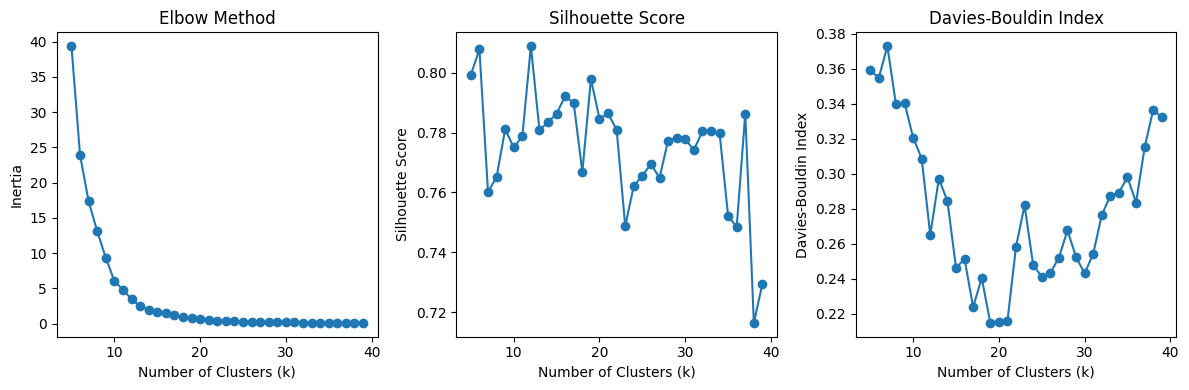

In [99]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from colorsys import hls_to_rgb
import matplotlib.cm as cm

# Define the range of k values
k_values = range(5, 40, 1)

# Initialize lists to store metric scores
inertia_values = []
silhouette_scores = []
davies_bouldin_scores = []

# Iterate over each value of k
for k in k_values:
    # Initialize and fit KMeans model
    kmeans = KMeans(n_clusters=k, max_iter=300)
    kmeans.fit(df)
    
    # Calculate inertia, silhouette score, and Davies-Bouldin index
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot silhouette score
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

# Plot Davies-Bouldin index
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')

plt.tight_layout()
plt.show()


In [ ]:
BEST_K = 30

kmeans = KMeans(n_clusters=BEST_K, max_iter=300)
kmeans.fit(df)
labels = kmeans.predict(df)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(5, 5))


# create a dictionnary with the color map matching a label and a color within a for loop
colmap = {i: hls_to_rgb(
                np.random.rand(), 
                (50 + np.random.rand() * 10) / 100., 
                (90 + np.random.rand() * 10) / 100.) for i in range(50)}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(df['PC1'], df['PC2'], color=colors, alpha=0.5, edgecolor=colors)

In [94]:
# Get the predicted labels and the number of clusters
pseudo_labels = labels
clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
print(f'\nClustering {percentage}% of the data: Found {clusters} ')

# # Compute evaluation metrics
# ari, ami, dbcv, per_cluster_dbcv = evaluation(cluster_ids, true_labels, clustering)
# print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCVavg: {np.mean(per_cluster_dbcv)}\n')



Clustering 100% of the data: Found 30 


In [95]:
# For each cluster, print the species with the number of points per species
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        print(f'Cluster {pseudo_label_id} :')
        for true_label_id in np.unique(true_labels) :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) > 0:
                print(f'    {species_dict[true_label_id]} : {np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id))}')

Cluster 0 :


NameError: name 'species_dict' is not defined

In [19]:
# Find the label in true_labels that are not present in pseudo_labels
missing_species_any_cluster = np.setdiff1d(true_labels, pseudo_labels)

print(f'{len(missing_species_any_cluster)} / {len(species_dict)} species are not present in any cluster.')

print("The list is:")
for nn in missing_species_any_cluster :
    print(f'    {species_dict[nn]}')


0 / 30 species are not present in any cluster.
The list is:


In [20]:
# list of labels corresponding to the most represented species in each cluster
label_to_cluster = []

# For each cluster, select the species with the most points and compute the percentage of points in the cluster
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        label_to_cluster += [np.unique(true_labels)[np.argmax([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) for true_label_id in np.unique(true_labels)])]]
        print(f'Cluster {pseudo_label_id} : {species_dict[label_to_cluster[-1]]} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label_to_cluster[-1])) / np.sum(pseudo_labels == pseudo_label_id) * 100).astype("int")}%')

Cluster 0 : Nyctidromus albicollis_Pauraque : 27%
Cluster 1 : Nyctibius grandis_Great Potoo : 33%
Cluster 2 : Tinamus major_Great Tinamou : 39%
Cluster 3 : Pulsatrix perspicillata_Spectacled Owl : 89%
Cluster 4 : Lurocalis semitorquatus_Short-tailed Nighthawk : 68%
Cluster 5 : Crypturellus cinereus_Cinereous Tinamou : 71%
Cluster 6 : Hydropsalis maculicaudus_Spot-tailed Nightjar : 66%
Cluster 7 : Micrastur ruficollis_Barred Forest Falcon : 98%
Cluster 8 : Crypturellus soui_Little Tinamou : 57%
Cluster 9 : Lophostrix cristata_Crested Owl : 94%
Cluster 10 : Strix virgata_Mottled Owl : 48%
Cluster 11 : Micrastur ruficollis_Barred Forest Falcon : 77%
Cluster 12 : Micrastur ruficollis_Barred Forest Falcon : 76%
Cluster 13 : Micrastur gilvicollis_Lined Forest Falcon : 66%
Cluster 14 : Micrastur ruficollis_Barred Forest Falcon : 85%
Cluster 15 : Nyctibius griseus_Common Potoo : 26%
Cluster 16 : Megascops watsonii_Tawny-bellied Screech Owl : 58%
Cluster 17 : Micrastur ruficollis_Barred Forest 

In [21]:
# list of species that are not the most represented in any cluster
missing_species_as_main_cluster = np.setdiff1d(np.unique(true_labels), label_to_cluster)

print(f'{len(missing_species_as_main_cluster)} / {len(species_dict)} species are not representing by a cluster.')

print("The list is:")
for label in missing_species_as_main_cluster :
    print(f'    {species_dict[label]}')

11 / 30 species are not representing by a cluster.
The list is:
    Chordeiles acutipennis_Lesser Nighthawk
    Nyctibius leucopterus_White-winged Potoo
    Hydropsalis cayennensis_White-tailed Nightjar
    Hydropsalis climacocerca_Ladder-tailed Nightjar
    Chordeiles nacunda_Nacunda Nighthawk
    Nyctipolus nigrescens_Blackish Nightjar
    Crypturellus variegatus_Variegated Tinamou
    Crypturellus brevirostris_Rusty Tinamou
    Megascops roraimae_Foothill Screech Owl
    Nyctibius aethereus_Long-tailed Potoo
    Nyctibius bracteatus_Rufous Potoo
